### Connection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from graphdatascience import GraphDataScience

URI = "neo4j://localhost:7687"
NAME_DB = "movies"

gds = GraphDataScience(URI, aura_ds=False, database=NAME_DB)

# Graph Analytics
In this section there will be two types of graph analysis:
- Similarity to create a recommendations systems
- Community detection

These two analysis will be done in a correlation way: results on similarity analysis will be use to do a better community detection.

## Similarity Analysis
Similarity analysis is done by considering the entire graph with all information added in preprocessing and exploratory analysis sections.  
![db_schema_after_exploratory.png](images/db_schema_after_exploratory.png)

As we can also see in the output of the second cell, the density of the graph is slightly increased with the added relations.  

Similarity analysis will be done in two way:
- Based on nodes relations
- Based on nodes properties  

So will be calculate similarity on Users and Movies nodes.  

In [2]:
result = gds.run_cypher(
    """
    CALL gds.graph.project(
    'movies-analyzed',
    {
        Movie:{properties:['popularity','favoriteMonth','year']},
        User:{properties: ['binaryGender','age','occupation', 'activity','favoriteMonth']},
        Genre:{}
    },
    {
        RATED: {properties: 'rating', orientation: 'UNDIRECTED'},
        BELONGS:{},
        LIKES:{properties: 'score', orientation: 'UNDIRECTED'}
    }
    )
    YIELD
    graphName AS graph, nodeProjection, nodeCount AS nodes, relationshipProjection, relationshipCount AS rels
"""
)
result

,graph,nodeProjection,nodes,relationshipProjection,rels
0,movies-analyzed,"{'User': {'label': 'User', 'properties': {'occ...",9764,"{'RATED': {'aggregation': 'DEFAULT', 'orientat...",2067010


In [3]:
gds.run_cypher(
    """
    CALL gds.graph.list('movies-analyzed')
    YIELD density,degreeDistribution;
"""
)

,density,degreeDistribution
0,0.021684,"{'min': 2, 'max': 3430, 'p90': 520, 'p999': 25..."


### Similarity based on relationships
In this similarity analysis will be used node the [Node Similarity](https://neo4j.com/docs/graph-data-science/current/algorithms/node-similarity/) algorithm in the Neo4j Graph Data Science library based on Jaccard similarity metrics.  


#### Users likes genres
This similarity analysis adds SIMILAR weighted relations between users with similar connections User-Genre.  
This analysis is most of time much higher because we don't have much heterogeneity between users connecting with genres.  
For this reason, relations were added from a similarity of 80%.  

In [4]:
result = gds.run_cypher(
    """
    CALL gds.nodeSimilarity.write('movies-analyzed',
    {
        nodeLabels:['User','Genre'],
        relationshipTypes:['LIKES'],
        relationshipWeightProperty: 'score', 
        similarityCutoff: 0.5,
        writeRelationshipType: 'SIMILAR',
        writeProperty: 'score'
    }) 
    """
)
print(f"Similarity relations created: {result.loc[0]['relationshipsWritten']}\n")
print(result.loc[0]["similarityDistribution"])

Similarity relations created: 60208

{'min': 0.5002517700195312, 'p5': 0.6166191101074219, 'max': 1.0000038146972656, 'p99': 0.969482421875, 'p1': 0.5825080871582031, 'p10': 0.6290702819824219, 'p90': 0.9297065734863281, 'p50': 0.6571502685546875, 'p25': 0.6438331604003906, 'p75': 0.8466644287109375, 'p95': 0.9481620788574219, 'mean': 0.7222428500509757, 'p100': 1.0000038146972656, 'stdDev': 0.12058239147704104}


#### Movies belongs genres
This similarity analysis adds SIMILAR weighted relations between movies with similar connections Movie-Genre.  
This analysis is most of time much higher because we don't have much diversification on the datasets.  
For this reason, relations were added from a similarity of 80%.  

In [5]:
result = gds.run_cypher(
    """
    CALL gds.nodeSimilarity.write('movies-analyzed',
    {
        nodeLabels:['Movie','Genre'],
        relationshipTypes:['BELONGS'], 
        similarityCutoff: 0.8,
        writeRelationshipType: 'SIMILAR',
        writeProperty: 'score'
    }) 
    """
)
print(f"Similarity relations created: {result.loc[0]['relationshipsWritten']}\n")
print(result.loc[0]["similarityDistribution"])

Similarity relations created: 33130

{'min': 0.7999992370605469, 'p5': 1.0000038146972656, 'max': 1.0000038146972656, 'p99': 1.0000038146972656, 'p1': 1.0000038146972656, 'p10': 1.0000038146972656, 'p90': 1.0000038146972656, 'p50': 1.0000038146972656, 'p25': 1.0000038146972656, 'p75': 1.0000038146972656, 'p95': 1.0000038146972656, 'mean': 0.999460488045068, 'p100': 1.0000038146972656, 'stdDev': 0.010410216796040048}


#### Users rate movies
This other similarity analysis adds SIMILAR_RATE weighted relations between users with similar connections User-Movie.  

This analysis is more precise and captures user behaviour within the network and finds more correct correlations.  
For this reason, relations were added from a similarity of 50%.  

In [6]:
result = gds.run_cypher(
    """
    CALL gds.nodeSimilarity.write('movies-analyzed',
    {
        nodeLabels:['User','Movie'],
        relationshipTypes:['RATED'], 
        similarityCutoff: 0.5,
        writeRelationshipType: 'SIMILAR_RATE',
        writeProperty: 'score',
        relationshipWeightProperty: 'rating'
    }) 
    """
)
print(f"Similarity relations created: {result.loc[0]['relationshipsWritten']}\n")
print(result.loc[0]["similarityDistribution"])

Similarity relations created: 524

{'min': 0.5, 'p5': 0.5, 'max': 1.0000038146972656, 'p99': 1.0000038146972656, 'p1': 0.5, 'p10': 0.5, 'p90': 1.0000038146972656, 'p50': 0.5999984741210938, 'p25': 0.5, 'p75': 1.0000038146972656, 'p95': 1.0000038146972656, 'mean': 0.7131035637309533, 'p100': 1.0000038146972656, 'stdDev': 0.2144020236922081}


#### Movies rated by users
This other similarity analysis adds SIMILAR_RATE weighted relations between movies with similar connections Movie-User.  

This analysis is more precise and captures  the popularity and appreciation of the movies within the network and finds more correct correlations.  
For this reason, relations were added from a similarity of 50%.  

In [7]:
result = gds.run_cypher(
    """
    CALL gds.nodeSimilarity.write('movies-analyzed',
    {
        nodeLabels:['Movie','User'],
        relationshipTypes:['RATED'], 
        relationshipWeightProperty: 'rating',
        similarityCutoff: 0.5,
        writeRelationshipType: 'SIMILAR_RATE',
        writeProperty: 'score'
    }) 
    """
)
print(f"Similarity relations created: {result.loc[0]['relationshipsWritten']}\n")
print(result.loc[0]["similarityDistribution"])

Similarity relations created: 524

{'min': 0.5, 'p5': 0.5, 'max': 1.0000038146972656, 'p99': 1.0000038146972656, 'p1': 0.5, 'p10': 0.5, 'p90': 1.0000038146972656, 'p50': 0.5999984741210938, 'p25': 0.5, 'p75': 1.0000038146972656, 'p95': 1.0000038146972656, 'mean': 0.7131035637309533, 'p100': 1.0000038146972656, 'stdDev': 0.2144020236922081}


### Similarity based on components
In this other similarity analysis will be used node the [K-Nearest Neighbors](https://neo4j.com/docs/graph-data-science/current/algorithms/knn/) algorithm in the Neo4j Graph Data Science library based on Jaccard similarity metrics.  

N.B.: concurrency:1 and randomSeed: 42 configurations are need to have same results on these tests

#### Users
This similarity analysis adds SIMILAR_KNN weighted relations between users with similar properties.  

For this reason, relations were added from a similarity of 70%.  

In [8]:
result = gds.run_cypher(
    """
    CALL gds.knn.write('movies-analyzed', {
        nodeLabels:['User'], 
        writeRelationshipType: 'SIMILAR_KNN',
        writeProperty: 'score',
        topK: 100, 
        concurrency: 1, 
        randomSeed: 42,
        similarityCutoff: 0.7,
        nodeProperties: ['binaryGender','age','occupation', 'activity','favoriteMonth']})
    """
)
print(f"Similarity relations created: {result.loc[0]['relationshipsWritten']}\n")
print(result.loc[0]["similarityDistribution"])

Similarity relations created: 547626

{'min': 0.6999969482421875, 'p5': 0.7095222473144531, 'max': 1.0000038146972656, 'p99': 1.0000038146972656, 'p1': 0.6999969482421875, 'p10': 0.7166633605957031, 'p90': 0.8666648864746094, 'p50': 0.7999992370605469, 'p25': 0.7333297729492188, 'p75': 0.8333320617675781, 'p95': 0.8999977111816406, 'mean': 0.7915988846093521, 'p100': 1.0000038146972656, 'stdDev': 0.06453635621702361}


#### Movies
This similarity analysis adds SIMILAR_KNN weighted relations between movies with similar properties.  

For this reason, relations were added from a similarity of 70%.  

In [9]:
result = gds.run_cypher(
    """
    CALL gds.knn.write('movies-analyzed', {
        nodeLabels:['Movie'],
        writeRelationshipType: 'SIMILAR_KNN',writeProperty: 'score',
        topK: 100,
        concurrency: 1,
        randomSeed: 42,
        similarityCutoff: 0.7,
        nodeProperties: ['popularity','favoriteMonth','year']})
    """
)
print(f"Similarity relations created: {result.loc[0]['relationshipsWritten']}\n")
print(result.loc[0]["similarityDistribution"])

Similarity relations created: 283139

{'min': 0.6999969482421875, 'p5': 0.7083320617675781, 'max': 1.0000038146972656, 'p99': 1.0000038146972656, 'p1': 0.6999969482421875, 'p10': 0.7222213745117188, 'p90': 1.0000038146972656, 'p50': 0.8333320617675781, 'p25': 0.75, 'p75': 0.8333320617675781, 'p95': 1.0000038146972656, 'mean': 0.8122405183609618, 'p100': 1.0000038146972656, 'stdDev': 0.07940430385169993}


## Recommendation Systems
After similarity analysis the graph become like this:  
![alt text](images/movies_with_similarity.svg)  
Having these information we can build a recommendation system mixed with relations similarity and components similarity.
  
Init our pseudo-random generator with fixed seed.

In [10]:
import random

random.seed(0)

### Movie based
We choose a random film from dataset

In [11]:
movieId = random.randint(0, 3952)

gds.run_cypher(
    f"""
    MATCH (m:Movie) WHERE m.movieId = {movieId}
    RETURN m.movieId as movieId,m.title as title
    """
).loc[0]["title"]

'Blood and Sand (Sangre y Arena) (1989)'

After that we pick 60 movies similar based our three similarity metrics (20 movies for each).  

We joins these three lists and calculate a mixed score metrics with different weights  
__general_score = scoreGenre * .2 + scoreRate * .5 + scoreKnn * .3__  

Sorts list by `general_score` and filter first 10


In [12]:
# I take the top 20 most similar films according to previously created similarity edges for each similarity type
list_with_similar_genre = gds.run_cypher(
    f"""
    MATCH (m:Movie WHERE m.movieId = {movieId})-[s:SIMILAR]-(m2:Movie)
    RETURN DISTINCT m2.movieId as movieId, s.score as scoreGenre
    ORDER BY scoreGenre DESC
    limit 20
    """
)
list_with_similar_rate = gds.run_cypher(
    f"""
    MATCH (m:Movie WHERE m.movieId = {movieId})-[s:SIMILAR_RATE]-(m2:Movie)
    RETURN DISTINCT m2.movieId as movieId, s.score as scoreRate
    ORDER BY scoreRate DESC
    limit 20
    """
)
list_with_similar_knn = gds.run_cypher(
    f"""
    MATCH (m:Movie WHERE m.movieId = {movieId})-[s:SIMILAR_KNN]-(m2:Movie)
    RETURN DISTINCT m2.movieId as movieId, s.score as scoreKnn
    ORDER BY scoreKnn DESC
    limit 20
    """
)

# I merge the lists
list = pd.merge(
    list_with_similar_genre, list_with_similar_rate, how="outer", on="movieId"
)
list = list.merge(list_with_similar_knn, how="outer", on="movieId")

# I fill in the missing values with 0
list.fillna(0, inplace=True)

# I calculate the general score
list["general_score"] = (
    list["scoreGenre"] * 0.2 + list["scoreRate"] * 0.5 + list["scoreKnn"] * 0.3
)

# I sort the list by general score and take the top 10
list.sort_values(by="general_score", ascending=False, inplace=True)
list.reset_index(drop=True, inplace=True)

# I pick the top 10 movies
list = list.head(10)

list

,movieId,scoreGenre,scoreRate,scoreKnn,general_score
0,3123,0.0,0.0,1.000000,0.300000
1,3166,0.0,0.0,1.000000,0.300000
2,706,0.0,0.6,0.000000,0.300000
3,2039,0.0,0.0,1.000000,0.300000
4,142,0.0,0.0,0.833333,0.250000
5,3687,0.0,0.0,0.833333,0.250000
6,1989,0.0,0.0,0.833333,0.250000
7,868,0.0,0.0,0.777778,0.233333
8,1107,0.0,0.0,0.777778,0.233333
9,895,0.0,0.0,0.750000,0.225000


With a simple query we can have our 10 recommended movies

In [13]:
gds.run_cypher(
    f"""
    MATCH (m:Movie) WHERE m.movieId IN {list['movieId'].tolist()}
    RETURN m.movieId as movieId,m.title as title
    """
)

,movieId,title
0,142,Shadows (Cienie) (1988)
1,706,Sunset Park (1996)
2,868,Death in Brunswick (1991)
3,895,Venice/Venice (1992)
4,1107,Loser (1991)
5,1989,Prom Night III: The Last Kiss (1989)
6,2039,Cheetah (1989)
7,3123,Spring Fever USA (a.k.a. Lauderdale) (1989)
8,3166,Brenda Starr (1989)
9,3687,Light Years (1988)


### User based
We choose a random user

In [14]:
userId = random.randint(1, 6040)

gds.run_cypher(
    f"""
    MATCH (u:User {{userId: {userId}}})
    RETURN u.gender as gender, u.age as age, u.occupation as occupation, u.activity as activity, u.favoriteMonth as favoriteMonth
    """
)

,gender,age,occupation,activity,favoriteMonth
0,M,1,10,4,8


After that we pick the top 30 user similar based our three similarity metrics (10 user for each).  

We joins these three lists and calculate a mixed score metrics with different weights  
__general_score = scoreGenre * .2 + scoreRate * .5 + scoreKnn * .3__  

Sorts list by `general_score` and filter first 10

In [15]:
# I take the top 10 most similar users according to previously created similarity edges for each similarity type
list_with_similar_genre = gds.run_cypher(
    f"""
    MATCH (u:User WHERE u.userId = {userId})-[s:SIMILAR]-(u2:User)
    RETURN DISTINCT u2.userId as userId, s.score as scoreGenre
    ORDER BY scoreGenre DESC
    limit 10
    """
)
list_with_similar_rate = gds.run_cypher(
    f"""
    MATCH (u:User WHERE u.userId = {userId})-[s:SIMILAR_RATE]-(u2:User)
    RETURN DISTINCT u2.userId as userId, s.score as scoreRate
    ORDER BY scoreRate DESC
    limit 10
    """
)
list_with_similar_knn = gds.run_cypher(
    f"""
    MATCH (u:User WHERE u.userId = {userId})-[s:SIMILAR_KNN]-(u2:User)
    RETURN DISTINCT u2.userId as userId, s.score as scoreKnn
    ORDER BY scoreKnn DESC
    limit 10
    """
)

# I merge the lists
list = pd.merge(
    list_with_similar_genre, list_with_similar_rate, how="outer", on="userId"
)
list = list.merge(list_with_similar_knn, how="outer", on="userId")

# I fill in the missing values with 0
list.fillna(0, inplace=True)

# I calculate the general score
list["general_score"] = (
    list["scoreGenre"] * 0.2 + list["scoreRate"] * 0.5 + list["scoreKnn"] * 0.3
)

# I sort the list by general score
list.sort_values(by="general_score", ascending=False, inplace=True)
list.reset_index(drop=True, inplace=True)

# I pick the top 10 users
list = list.head(10)

list

/tmp/ipykernel_1766/3860210370.py:34: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  list.fillna(0, inplace=True)


,userId,scoreGenre,scoreRate,scoreKnn,general_score
0,3710,0.0,0,1.000000,0.30
1,3537,0.0,0,1.000000,0.30
2,3382,0.0,0,0.900000,0.27
3,3667,0.0,0,0.900000,0.27
4,3843,0.0,0,0.900000,0.27
5,4997,0.0,0,0.900000,0.27
6,4102,0.0,0,0.900000,0.27
7,3865,0.0,0,0.900000,0.27
8,3573,0.0,0,0.866667,0.26
9,3904,0.0,0,0.866667,0.26


Having the 10 most similar people, for each one I select the 3 most liked films that have not yet been seen by the person taken as an example. 

I group the results and if I find films recommended by several people I add up their general_score.

Finally I select the top 10

In [16]:
# I take the top 3 favorite movies of the top 10 similar users
movies_list = pd.DataFrame()
for _, similar_user in list.iterrows():
    favorite_movies = gds.run_cypher(
        f"""
        MATCH (uSample:User{{userId: {userId}}})
        MATCH (u:User {{userId: {similar_user['userId']}}})-[r:RATED]->(m:Movie)
        WHERE NOT (uSample)-[:RATED]->(m)
        RETURN m.movieId as movieId, r.rating as rating
        ORDER BY rating DESC
        LIMIT 3
        """
    )
    favorite_movies["general_score"] = similar_user["general_score"]
    movies_list = pd.concat([movies_list, favorite_movies])

# I group the results and if I find the movies recommended by more people I sum their general_score.
movies_list = movies_list.groupby(by="movieId").agg(
    {"general_score": "sum", "rating": "size"}
)
movies_list.columns = ["general_score", "times"]

# I sort the list by general score and take the top 10
movies_list.sort_values(by="general_score", ascending=False, inplace=True)
movies_list = movies_list.head(10)

movies_list

,general_score,times
movieId,,
1223,0.30,1
3646,0.30,1
2795,0.30,1
3752,0.30,1
3744,0.30,1
2027,0.30,1
1214,0.27,1
810,0.27,1
1088,0.27,1


With a simple query we can have our 10 recommended movies

In [17]:
gds.run_cypher(
    f"""
    MATCH (m:Movie) WHERE m.movieId IN {movies_list.index.to_list()}
    RETURN m.movieId as movieId,m.title as title
    """
)

,movieId,title
0,356,Forrest Gump (1994)
1,810,Kazaam (1996)
2,1088,Dirty Dancing (1987)
3,1214,Alien (1979)
4,1223,Grand Day Out A (1992)
5,2027,Mafia! (1998)
6,2795,Vacation (1983)
7,3646,Big Momma's House (2000)
8,3744,Shaft (2000)
9,3752,Me Myself and Irene (2000)


## Community detection
Thanks to similarity analysis we have a subgraph on which we can do community detection.  
This is the structure of `users-similarities`  
![alt text](images/users_similarities.svg)  

This one is a little part of the graph with 300 Users nodes  
![alt text](images/users_similarities_300_nodes.svg)
 

In [18]:
result = gds.run_cypher(
    """
    CALL gds.graph.project(
    'users-similarities',
    'User',
    {
        SIMILAR_KNN: {properties: 'score', orientation: 'UNDIRECTED'},
        SIMILAR: {properties: 'score', orientation: 'UNDIRECTED'},
        SIMILAR_RATE: {properties: 'score', orientation: 'UNDIRECTED'}
    }
    )
    YIELD
    graphName AS graph, nodeProjection, nodeCount AS nodes, relationshipProjection, relationshipCount AS rels
"""
)
result

,graph,nodeProjection,nodes,relationshipProjection,rels
0,users-similarities,"{'User': {'label': 'User', 'properties': {}}}",6040,"{'SIMILAR_RATE': {'aggregation': 'DEFAULT', 'o...",1215708


In [19]:
gds.run_cypher(
    """
    CALL gds.graph.list('users-similarities')
    YIELD density,degreeDistribution;
"""
)

,density,degreeDistribution
0,0.033329,"{'min': 16, 'max': 349, 'p90': 271, 'p999': 33..."


### Check some stats from Neo4j algorithms

#### Strongly Connected Components
The network is an entire strongly connected component

In [20]:
gds.run_cypher(
    """
    CALL gds.scc.stats('users-similarities')
    YIELD componentCount, componentDistribution
    """
)

,componentCount,componentDistribution
0,1,"{'min': 6040, 'p5': 6040, 'max': 6040, 'p999':..."


#### Louvain stats
The [louvain](https://neo4j.com/docs/graph-data-science/current/algorithms/louvain/) stats find 7-8 community with a good modularity (0.3<Q<0.7).  

In [21]:
gds.run_cypher(
    """
    CALL gds.louvain.stats('users-similarities', 
    { 
        relationshipWeightProperty: 'score'
    })
    YIELD communityCount, modularity, modularities
"""
)

,communityCount,modularity,modularities
0,8,0.62959,"[0.5029978892993425, 0.6192833566094449, 0.629..."


### Define communities

In [22]:
gds.run_cypher(
    """
    CALL gds.louvain.write('users-similarities', 
    { 
        writeProperty:'communityId',
        relationshipWeightProperty: 'score'
    })
    YIELD communityCount, modularity, modularities
"""
)

,communityCount,modularity,modularities
0,8,0.629767,"[0.5322522795511776, 0.6213104728481009, 0.629..."


In [3]:
result = gds.run_cypher(
    """
    MATCH (u:User)
    RETURN u.communityId as communityId, COUNT(*) as numNodes
    ORDER BY numNodes DESC
    
    """
)
communityId1 = result.iloc[0]["communityId"]
communityId2 = result.iloc[1]["communityId"]
result

,communityId,numNodes
0,3117,1260
1,5477,1193
2,5491,1103
3,3722,836
4,2568,550
5,894,496
6,2592,380
7,2656,222


### Community1 vs Community2

#### Users

##### Prepare data for comparison

In [15]:
from helpers import AGE_LABELS, OCCUPATION_LABELS

users = gds.run_cypher(
    f"""
    MATCH (u:User)
    RETURN u.age AS age, u.occupation AS occupation, u.gender AS gender, u.favoriteMonth AS favoriteMonth, u.activity AS activity, u.communityId AS communityId
    """
)

genders_label = (
    pd.Series(index=users.gender.value_counts().index.to_list()).fillna(0).astype(int)
)
ages_label = pd.Series(index=AGE_LABELS.values()).fillna(0).astype(int)
occupations_label = pd.Series(index=OCCUPATION_LABELS.values()).fillna(0).astype(int)
activities_label = (
    pd.Series(index=users.activity.value_counts().index.to_list()).fillna(0).astype(int)
)
favoriteMonths_label = (
    pd.Series(index=users.favoriteMonth.value_counts().index.astype(int).to_list())
    .fillna(0)
    .astype(int)
)

genders = pd.DataFrame(
    {
        "Community 1": genders_label.combine(
            users["gender"][users["communityId"] == communityId1].value_counts(), max
        ),
        "Community 2": genders_label.combine(
            users["gender"][users["communityId"] == communityId2].value_counts(), max
        ),
    },
    index=genders_label.index,
)

ages = pd.DataFrame(
    {
        "Community 1": ages_label.combine(
            users["age"][users["communityId"] == communityId1]
            .value_counts()
            .rename(index=AGE_LABELS),
            max,
        ),
        "Community 2": ages_label.combine(
            users["age"][users["communityId"] == communityId2]
            .value_counts()
            .rename(index=AGE_LABELS),
            max,
        ),
    },
    index=ages_label.index,
)

occupations = pd.DataFrame(
    {
        "Community 1": occupations_label.combine(
            users["occupation"][users["communityId"] == communityId1]
            .value_counts()
            .rename(index=OCCUPATION_LABELS),
            max,
        ),
        "Community 2": occupations_label.combine(
            users["occupation"][users["communityId"] == communityId2]
            .value_counts()
            .rename(index=OCCUPATION_LABELS),
            max,
        ),
    },
    index=occupations_label.index,
)

activities = pd.DataFrame(
    {
        "Community 1": activities_label.combine(
            users["activity"][users["communityId"] == communityId1].value_counts(), max
        ),
        "Community 2": activities_label.combine(
            users["activity"][users["communityId"] == communityId2].value_counts(), max
        ),
    },
    index=activities_label.index,
)

favoriteMonths = pd.DataFrame(
    {
        "Community 1": favoriteMonths_label.combine(
            users["favoriteMonth"][users["communityId"] == communityId1].value_counts(),
            max,
        ),
        "Community 2": favoriteMonths_label.combine(
            users["favoriteMonth"][users["communityId"] == communityId2].value_counts(),
            max,
        ),
    },
    index=favoriteMonths_label.index,
)

##### Comparison

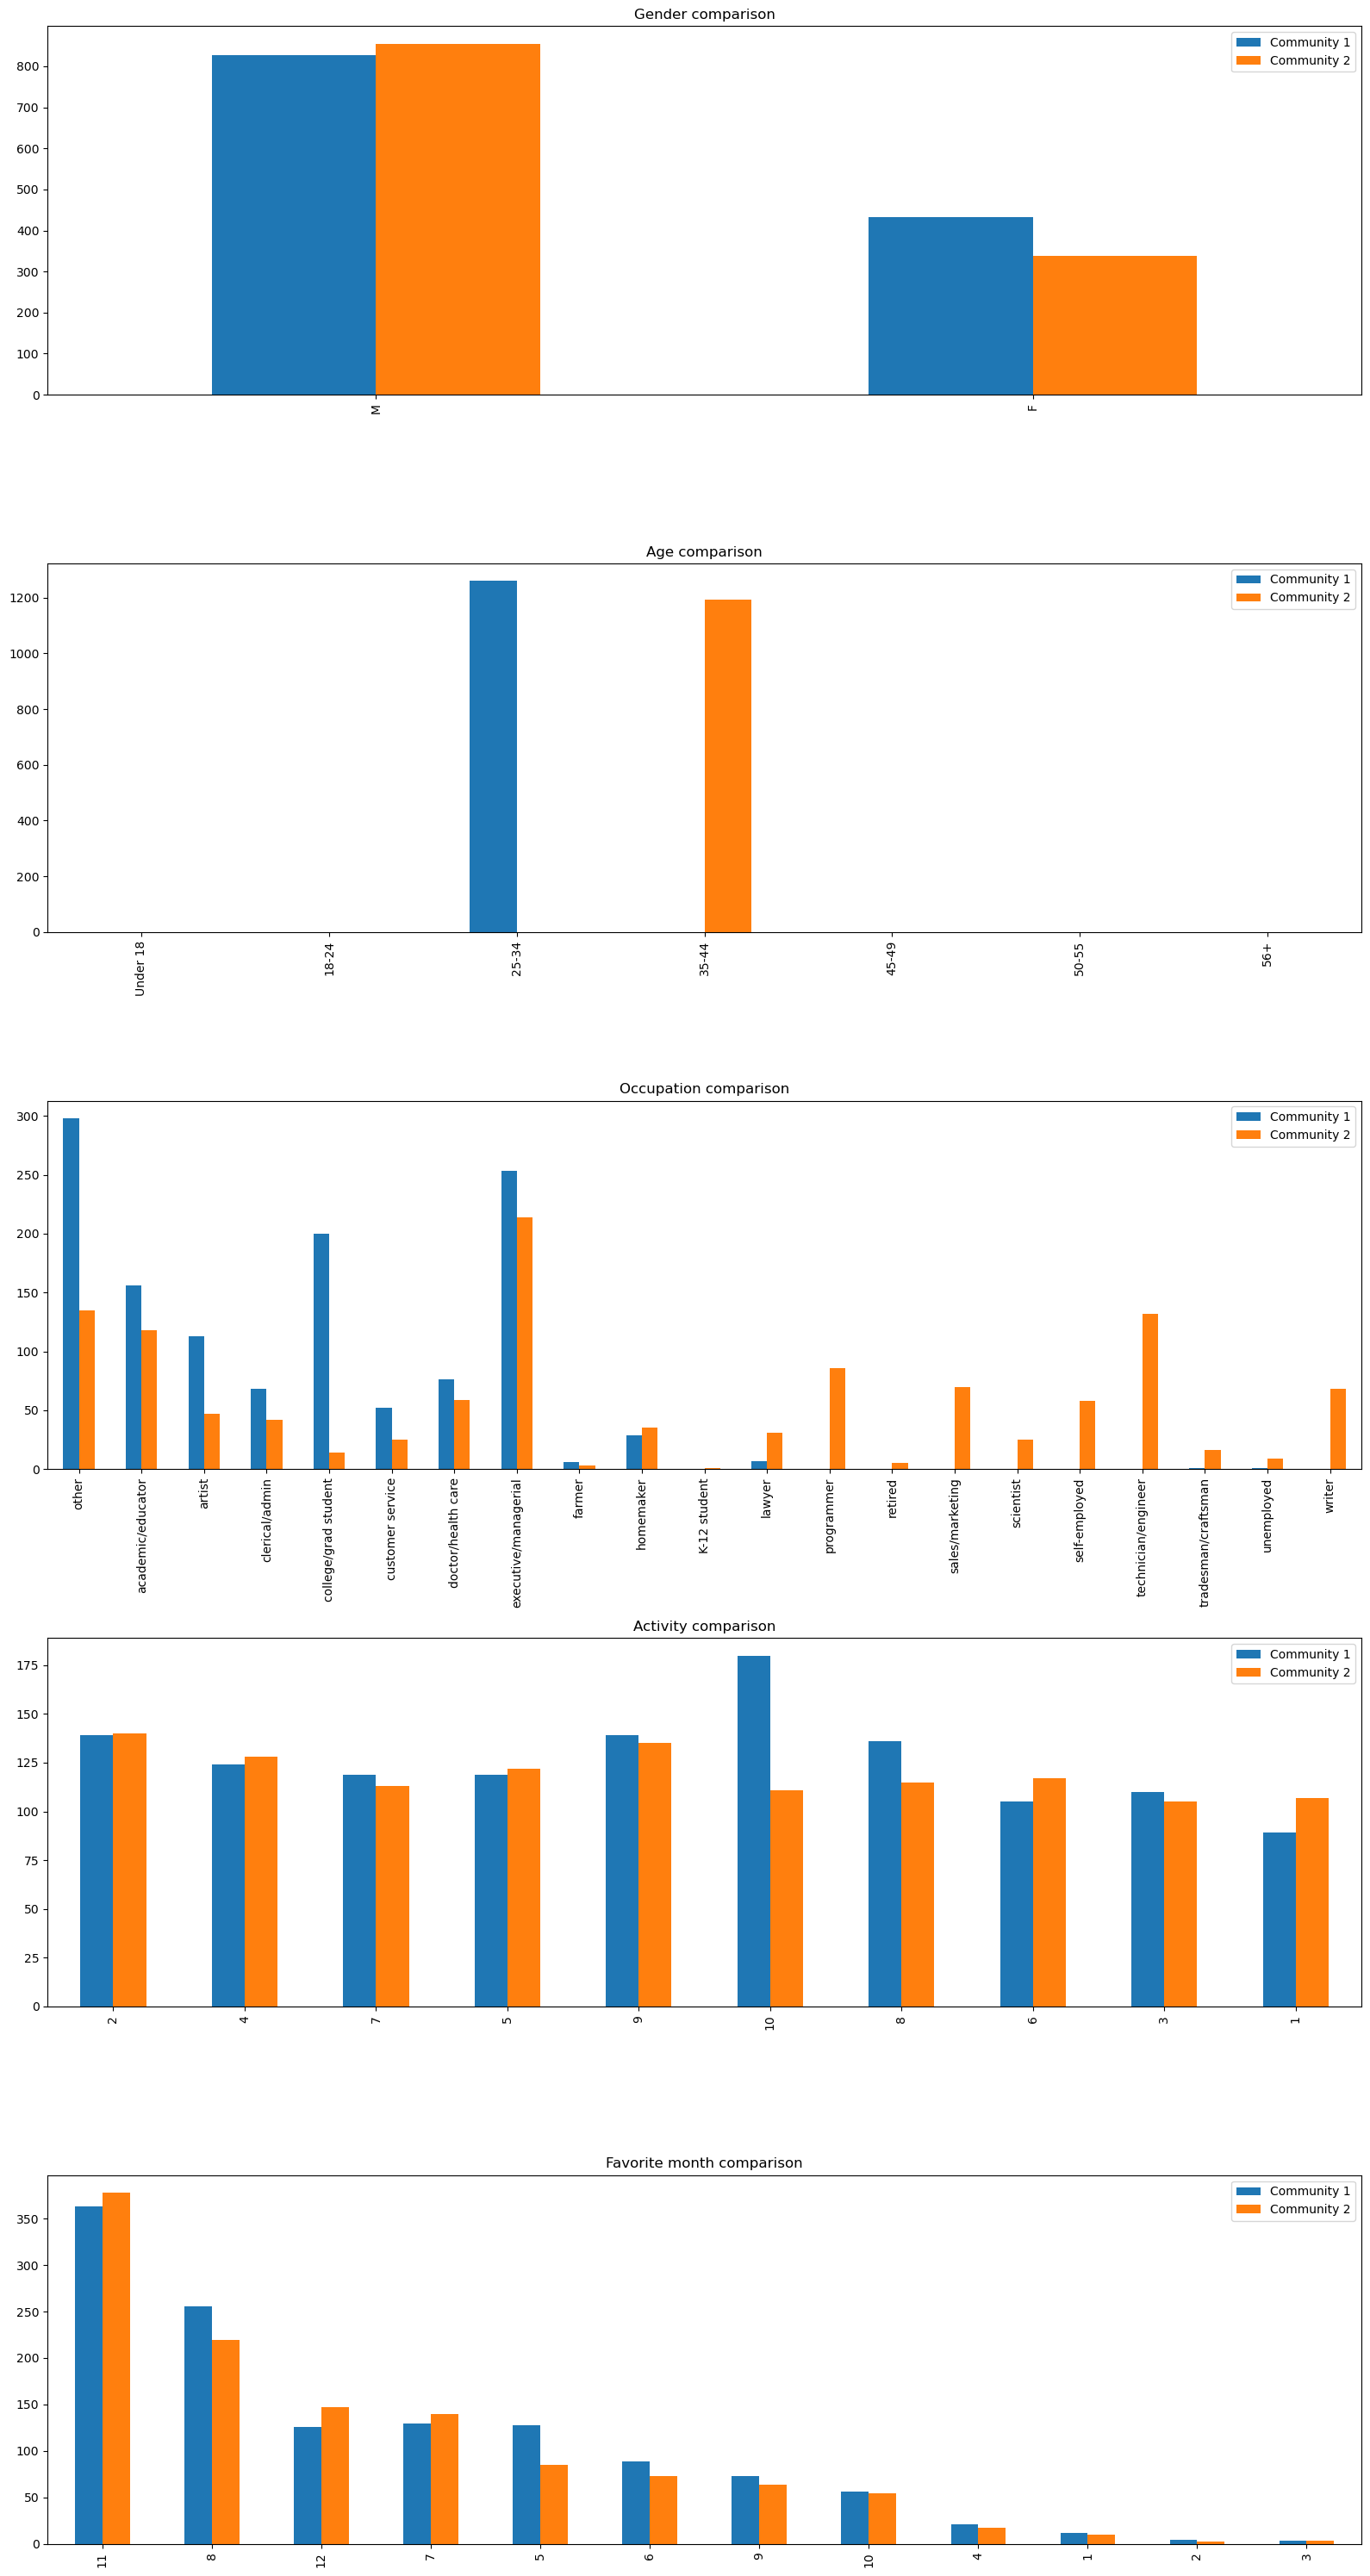

In [16]:
fig, axs = plt.subplots(5, 1, figsize=(16, 30))

genders.plot(kind="bar", ax=axs[0], title="Gender comparison")
ages.plot(kind="bar", ax=axs[1], title="Age comparison")
occupations.plot(kind="bar", ax=axs[2], title="Occupation comparison")
activities.plot(kind="bar", ax=axs[3], title="Activity comparison")
favoriteMonths.plot(kind="bar", ax=axs[4], title="Favorite month comparison")

plt.tight_layout()

#### Movies

##### Prepare data for comparison

In [15]:
movies_1 = gds.run_cypher(
    f"""
    MATCH (u:User WHERE u.communityId={communityId1})-[r:RATED]->(m:Movie)
    RETURN m.title AS title, m.year AS year, m.popularity AS popularity
    """
)
movies_2 = gds.run_cypher(
    f"""
    MATCH (u:User WHERE u.communityId={communityId2})-[r:RATED]->(m:Movie)
    RETURN m.title AS title, m.year AS year, m.popularity AS popularity
    """
)

##### Comparison

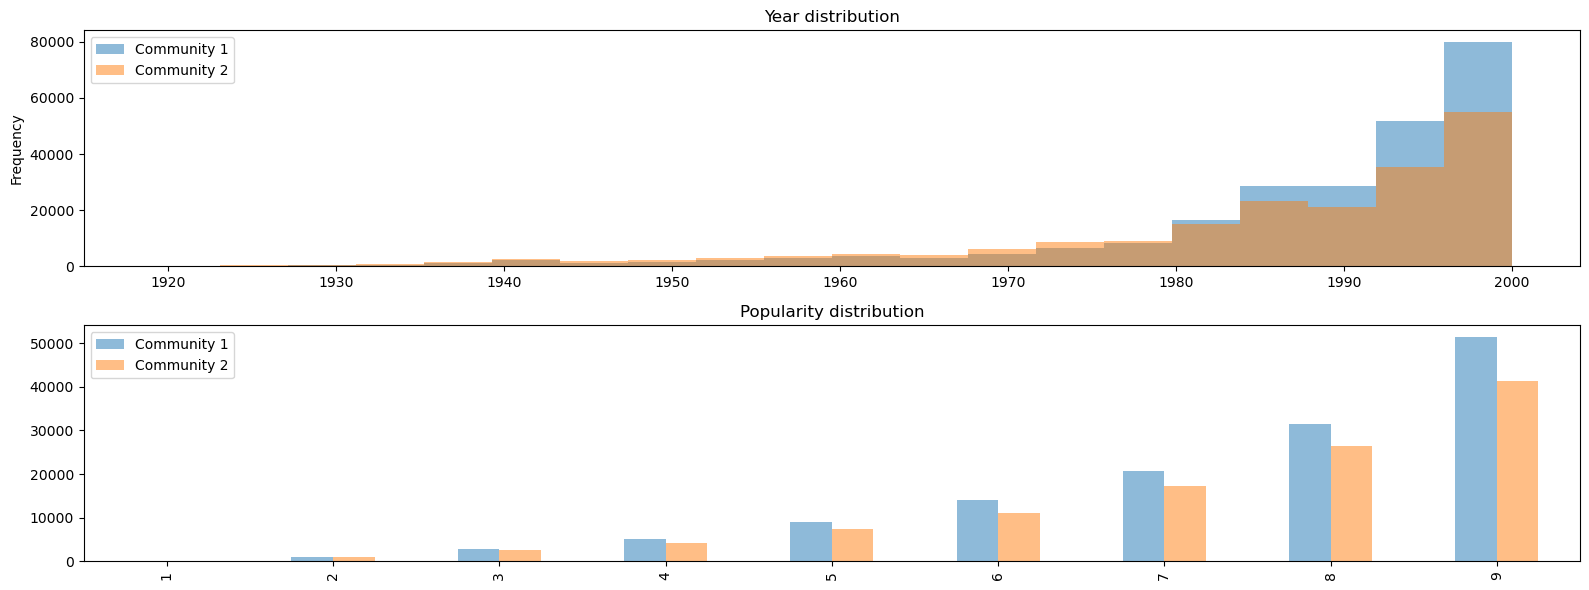

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(16, 6))

popularity_label = pd.Series(index=range(1, 10)).fillna(0).astype(int)

pd.DataFrame(
    {
        "Community 1": movies_1["year"].sort_values(),
        "Community 2": movies_2["year"].sort_values(),
    }
).plot(kind="hist", bins=20, alpha=0.5, title="Year distribution", ax=axs[0])

pd.DataFrame(
    {
        "Community 1": popularity_label.combine(
            movies_1["popularity"].value_counts(), max
        ),
        "Community 2": popularity_label.combine(
            movies_2["popularity"].value_counts(), max
        ),
    },
    index=range(1, 10),
).plot(kind="bar", alpha=0.5, title="Popularity distribution", ax=axs[1])

plt.tight_layout()

# Conclusions